Dataset: https://physionet.org/content/noneeg/1.0.0/

Preprocessing: https://github.com/yehiaabdelm/assessing-neurological-status


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
pip install wfdb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 3.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import wfdb
from dataclasses import dataclass
import numpy as np
from tqdm import tqdm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.model_selection import cross_val_score,KFold,RepeatedKFold,LeaveOneOut,train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load & Preprocess Data

In [ ]:
#Nakhla
dataset_dir = '/content/drive/MyDrive/Data Mining project/Dataset/'

In [ ]:
all_subjects = []

# Loop through all 20 subjects to load their data
for i in tqdm(range(20)):
    # Update the file paths to read from Google Drive
    spO2_HR_file = f'{dataset_dir}Subject{i+1}_SpO2HR'
    acc_temp_eda_file = f'{dataset_dir}Subject{i+1}_AccTempEDA'
    annotation_file = f'{dataset_dir}Subject{i+1}_AccTempEDA'

    # Load the signals for SpO2 & HR, AccTemp & EDA, and annotations
    spO2_HR_data = wfdb.rdrecord(spO2_HR_file)
    acc_temp_eda_data = wfdb.rdrecord(acc_temp_eda_file)
    annotations = wfdb.rdann(annotation_file, 'atr')

    # Initialize the stress labels (empty lists for now)
    stress_labels = {'Relax': [], 'PhysicalStress': [], 'EmotionalStress': [], 'CognitiveStress': []}

100%|██████████| 20/20 [00:27<00:00,  1.40s/it]


In [ ]:
@dataclass
class Subject:
  SpO2HR: wfdb.io.record.Record
  AccTempEDA: wfdb.io.record.Record
  AccTempEDAAnn: wfdb.io.annotation.Annotation
  signals: dict

In [ ]:
# import all subjects into one list
all_subjects = []
for i in tqdm(range(20)):
  all_subjects.append(Subject(wfdb.rdrecord(f'Subject{i+1}_SpO2HR', pn_dir='noneeg/1.0.0/'),
                              wfdb.rdrecord(f'Subject{i+1}_AccTempEDA', pn_dir='noneeg/1.0.0/'),
                              wfdb.rdann(f'Subject{i+1}_AccTempEDA', 'atr', pn_dir='noneeg/1.0.0/'),
                              {'Relax':[],'PhysicalStress':[],'EmotionalStress':[],'CognitiveStress':[]}))

100%|██████████| 20/20 [00:13<00:00,  1.44it/s]


In [ ]:
# plot any subjects signal readings with annotations representing start/stop of stage
def subject_plot(i):
  wfdb.plot_wfdb(record = all_subjects[i].AccTempEDA,annotation=all_subjects[i].AccTempEDAAnn, time_units='minutes')
  wfdb.plot_wfdb(record = all_subjects[i].SpO2HR,annotation=all_subjects[i].AccTempEDAAnn, time_units='minutes')

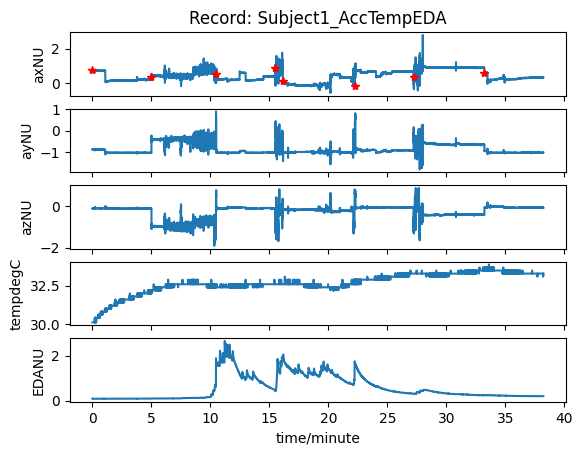

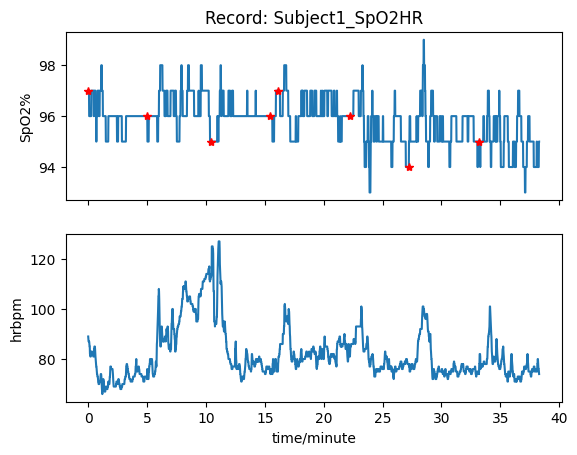

In [ ]:
subject_plot(0)

In [ ]:
for i in tqdm(range(20)):
  sample = all_subjects[i].AccTempEDAAnn.__dict__['sample'] # sample name (for those with 8 per second)
  stages = all_subjects[i].AccTempEDAAnn.__dict__['aux_note'] #stage name
  signals = all_subjects[i].AccTempEDA.__dict__['p_signal'] #signal of those with 8 per sec
  hr_spo2 = all_subjects[i].SpO2HR.__dict__['p_signal'] #signal of one sample per sec
  sample_hr = np.floor(sample/8).astype(int) # change sample to be 1sample per sec instead of 8 per sec
  for j in range(len(stages)):
    if j!=7:
      all_subjects[i].signals[stages[j]].append({'ax':signals[sample[j]:sample[j+1],0],
                                                 'ay':signals[sample[j]:sample[j+1],1],
                                                 'az':signals[sample[j]:sample[j+1],2],
                                                 'temp':signals[sample[j]:sample[j+1],3],
                                                 'EDA':signals[sample[j]:sample[j+1],4],
                                                 'spo2':hr_spo2[sample_hr[j]:sample_hr[j+1],0],
                                                 'hr':hr_spo2[sample_hr[j]:sample_hr[j+1],1],
                                                 })
    else:
      all_subjects[i].signals[stages[j]].append({'ax':signals[sample[j]:,0],
                                                 'ay':signals[sample[j]:,1],
                                                 'az':signals[sample[j]:,2],
                                                 'temp':signals[sample[j]:,3],
                                                 'EDA':signals[sample[j]:,4],
                                                 'spo2':hr_spo2[sample_hr[j]:,0],
                                                 'hr':hr_spo2[sample_hr[j]:,1],
                                                 })

100%|██████████| 20/20 [00:00<00:00, 3642.63it/s]


In [ ]:
all_subjects[0].signals['PhysicalStress'][0]['ax']

array([0.35000214, 0.31001205, 0.29004242, ..., 0.47002319, 0.44004334,
       0.31001205])

In [ ]:
var = ['ax','ay','az','EDA','temp','spo2','hr']
minimum_values_accEDA = {'Relax':2384,'PhysicalStress':2593,'EmotionalStress':320,'CognitiveStress':2769}
minimum_values_sp02hr = {'Relax':298,'PhysicalStress':298,'EmotionalStress':40,'CognitiveStress':298}
ite = [4,1,2,1] # number of times a stage is repeated (i.e. there are four relaxed stages)
types = ['Relax','PhysicalStress','EmotionalStress', 'CognitiveStress']

In [ ]:
for i in tqdm(range(20)): # loop over subjects
    for k in range(4): # identify which state you're in
      for w in range(ite[k]): # the number of times we will loop for each state
        for v in var: # loop over all variables
          if v in ['spo2','hr']: # if in spo2/hr then use the min values for those
              minimum = minimum_values_sp02hr[types[k]]
              all_subjects[i].signals[types[k]][w][v] = np.resize(all_subjects[i].signals[types[k]][w][v],new_shape=(minimum,))
          else: # else use the min values for the others
              minimum = minimum_values_accEDA[types[k]]
              all_subjects[i].signals[types[k]][w][v] = np.resize(all_subjects[i].signals[types[k]][w][v],new_shape=(minimum,))

100%|██████████| 20/20 [00:00<00:00, 798.69it/s]


In [ ]:
df = pd.DataFrame(columns=['vector','subject','stage','label'])
df = df.astype({'subject':int,'stage':str,'label':int})

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm

# Example initialization (adapt according to your actual data structure)
eta = 8
X = np.array([])
y = np.array([])
df_list = []  # List to collect rows for DataFrame

size1 = int(eta)
size2 = int(size1 / 8)
for person in tqdm(range(20)):  # Loop over subjects
    for k in range(4):
        idx1 = int(minimum_values_accEDA[types[k]] / size1)
        idx2 = int(minimum_values_sp02hr[types[k]] / size2)
        for i in range(min(idx1, idx2)):
            for j in range(ite[k]):  # Types
                x = np.concatenate([
                    all_subjects[person].signals[types[k]][j]['ax'][size1*i:(i+1)*size1],
                    all_subjects[person].signals[types[k]][j]['ay'][size1*i:(i+1)*size1],
                    all_subjects[person].signals[types[k]][j]['az'][size1*i:(i+1)*size1],
                    all_subjects[person].signals[types[k]][j]['EDA'][size1*i:(i+1)*size1],
                    all_subjects[person].signals[types[k]][j]['temp'][size1*i:(i+1)*size1],
                    all_subjects[person].signals[types[k]][j]['spo2'][size2*i:(i+1)*size2],
                    all_subjects[person].signals[types[k]][j]['hr'][size2*i:(i+1)*size2]
                ])
                X = np.append(X, x)
                y = np.append(y, k)
                # Append row as dictionary to the list
                df_list.append({
                    'vector': x,
                    'subject': int(person + 1),
                    'stage': types[k],
                    'label': k
                })

# Convert list of dictionaries to a DataFrame
df = pd.DataFrame(df_list)


100%|██████████| 20/20 [00:34<00:00,  1.73s/it]


In [ ]:
X = X.reshape(37360,42)

In [ ]:
# Print the shape of each vector in the vector column
vector_shapes = df['vector'].apply(lambda x: np.array(x).shape)
print(vector_shapes)

# Alternatively, print unique shapes if all vectors are of consistent size
unique_shapes = vector_shapes.unique()
print("Unique shapes of vectors:", unique_shapes)


0        (42,)
1        (42,)
2        (42,)
3        (42,)
4        (42,)
         ...  
37355    (42,)
37356    (42,)
37357    (42,)
37358    (42,)
37359    (42,)
Name: vector, Length: 37360, dtype: object
Unique shapes of vectors: [(42,)]


In [ ]:
import pandas as pd
import numpy as np

# Example feature lengths (adjust based on your actual data structure)
# Assuming vector contains [ax, ay, az, EDA, temp, spo2, hr], where:
# - ax, ay, az: 2 samples each
# - EDA: 2 samples
# - temp: 2 samples
# - spo2: 1 sample
# - hr: 1 sample
feature_lengths = {
    'ax': 8,    # 8 samples for x-axis accelerometer
    'ay': 8,    # 8 samples for y-axis accelerometer
    'az': 8,    # 8 samples for z-axis accelerometer
    'EDA': 8,   # 8 samples for EDA
    'temp': 8,  # 8 samples for temperature
    'spo2': 1,  # 1 sample for SpO2
    'hr': 1     # 1 sample for heart rate
}

# Generate column names based on the feature_lengths
columns = []
for feature, length in feature_lengths.items():
    columns.extend([f"{feature}_{i+1}" for i in range(length)])

# Function to split vector into separate features
def split_features(vector, feature_lengths):
    split_indices = np.cumsum([0] + list(feature_lengths.values()))
    split_vectors = np.split(vector, split_indices[1:-1])
    return np.hstack(split_vectors)

# Create a new DataFrame with expanded features
expanded_data = []
for _, row in df.iterrows():
    vector = row['vector']
    features = split_features(vector, feature_lengths)
    expanded_row = dict(zip(columns, features))
    expanded_row['subject'] = row['subject']
    expanded_row['stage'] = row['stage']
    expanded_row['label'] = row['label']
    expanded_data.append(expanded_row)

# Convert the expanded data into a DataFrame
expanded_df = pd.DataFrame(expanded_data)

# Display the expanded DataFrame
expanded_df.head()


,ax_1,ax_2,ax_3,ax_4,ax_5,ax_6,ax_7,ax_8,ay_1,ay_2,...,temp_4,temp_5,temp_6,temp_7,temp_8,spo2_1,hr_1,subject,stage,label
0,0.770025,0.750005,0.770025,0.750005,0.750005,0.750005,0.750005,0.750005,-0.869990,-0.869990,...,30.100043,30.100043,30.100043,30.100043,30.100043,96.999969,89.000763,1,Relax,0
1,0.520023,0.630034,0.470023,0.680035,0.530034,0.590044,0.440043,0.430033,0.469963,0.899998,...,32.399966,32.599957,32.399966,32.399966,32.399966,95.000031,113.999649,1,Relax,0
2,-0.139991,0.030031,-0.009959,0.330033,0.150001,0.130031,0.200001,0.280032,-0.649971,-0.619963,...,32.599957,32.899973,32.599957,32.599957,32.599957,96.000000,81.000412,1,Relax,0
3,0.600004,0.610014,0.600004,0.600004,0.600004,0.600004,0.600004,0.600004,-0.949970,-0.949970,...,33.499945,33.699994,33.699994,33.499945,33.499945,95.000031,75.000381,1,Relax,0
4,0.760015,0.760015,0.760015,0.750005,0.760015,0.760015,0.750005,0.750005,-0.869990,-0.869990,...,30.100043,30.100043,30.100043,30.100043,30.100043,96.999969,88.000137,1,Relax,0


In [ ]:
# Import necessary library
import pandas as pd

# Load the demographic information CSV file
demographics_file = '/content/drive/MyDrive/Data Mining project/Dataset/subjectinfo.csv'
demographics_df = pd.read_csv(demographics_file)

# Merge the demographic information with the expanded dataset
# Use the 'subject' column as the key for merging
expanded_df_with_demographics = expanded_df.merge(demographics_df, on='subject', how='left')

# Display the first few rows of the new dataset
print(expanded_df_with_demographics.head())


       ax_1      ax_2      ax_3      ax_4      ax_5      ax_6      ax_7  \
0  0.770025  0.750005  0.770025  0.750005  0.750005  0.750005  0.750005   
1  0.520023  0.630034  0.470023  0.680035  0.530034  0.590044  0.440043   
2 -0.139991  0.030031 -0.009959  0.330033  0.150001  0.130031  0.200001   
3  0.600004  0.610014  0.600004  0.600004  0.600004  0.600004  0.600004   
4  0.760015  0.760015  0.760015  0.750005  0.760015  0.760015  0.750005   

       ax_8      ay_1      ay_2  ...     temp_8     spo2_1        hr_1  \
0  0.750005 -0.869990 -0.869990  ...  30.100043  96.999969   89.000763   
1  0.430033  0.469963  0.899998  ...  32.399966  95.000031  113.999649   
2  0.280032 -0.649971 -0.619963  ...  32.599957  96.000000   81.000412   
3  0.600004 -0.949970 -0.949970  ...  33.499945  95.000031   75.000381   
4  0.750005 -0.869990 -0.869990  ...  30.100043  96.999969   88.000137   

   subject  stage  label  age  gender  height/cm  weight/kg  
0        1  Relax      0   30       M     

In [ ]:
# Numerically encode the gender column
expanded_df_with_demographics['gender'] = expanded_df_with_demographics['gender'].map({'M': 1, 'F': 0})

# Display the first few rows to verify the encoding
print(expanded_df_with_demographics.head())


       ax_1      ax_2      ax_3      ax_4      ax_5      ax_6      ax_7  \
0  0.770025  0.750005  0.770025  0.750005  0.750005  0.750005  0.750005   
1  0.520023  0.630034  0.470023  0.680035  0.530034  0.590044  0.440043   
2 -0.139991  0.030031 -0.009959  0.330033  0.150001  0.130031  0.200001   
3  0.600004  0.610014  0.600004  0.600004  0.600004  0.600004  0.600004   
4  0.760015  0.760015  0.760015  0.750005  0.760015  0.760015  0.750005   

       ax_8      ay_1      ay_2  ...     temp_8     spo2_1        hr_1  \
0  0.750005 -0.869990 -0.869990  ...  30.100043  96.999969   89.000763   
1  0.430033  0.469963  0.899998  ...  32.399966  95.000031  113.999649   
2  0.280032 -0.649971 -0.619963  ...  32.599957  96.000000   81.000412   
3  0.600004 -0.949970 -0.949970  ...  33.499945  95.000031   75.000381   
4  0.750005 -0.869990 -0.869990  ...  30.100043  96.999969   88.000137   

   subject  stage  label  age  gender  height/cm  weight/kg  
0        1  Relax      0   30       1     

In [ ]:
# Drop the 'stage' column from the DataFrame
expanded_df_with_demographics = expanded_df_with_demographics.drop(columns=['stage'])

# Display the first few rows to confirm the column has been dropped
print(expanded_df_with_demographics.head())


       ax_1      ax_2      ax_3      ax_4      ax_5      ax_6      ax_7  \
0  0.770025  0.750005  0.770025  0.750005  0.750005  0.750005  0.750005   
1  0.520023  0.630034  0.470023  0.680035  0.530034  0.590044  0.440043   
2 -0.139991  0.030031 -0.009959  0.330033  0.150001  0.130031  0.200001   
3  0.600004  0.610014  0.600004  0.600004  0.600004  0.600004  0.600004   
4  0.760015  0.760015  0.760015  0.750005  0.760015  0.760015  0.750005   

       ax_8      ay_1      ay_2  ...     temp_7     temp_8     spo2_1  \
0  0.750005 -0.869990 -0.869990  ...  30.100043  30.100043  96.999969   
1  0.430033  0.469963  0.899998  ...  32.399966  32.399966  95.000031   
2  0.280032 -0.649971 -0.619963  ...  32.599957  32.599957  96.000000   
3  0.600004 -0.949970 -0.949970  ...  33.499945  33.499945  95.000031   
4  0.750005 -0.869990 -0.869990  ...  30.100043  30.100043  96.999969   

         hr_1  subject  label  age  gender  height/cm  weight/kg  
0   89.000763        1      0   30       1 

Relax: Label 0
PhysicalStress: Label 1
EmotionalStress: Label 2
CognitiveStress: Label 3


Male: Label 1
Female: Label 0

# **Dimensionality Reduction:**

#PCA

Explained variance ratio of each component: [0.25865135 0.24568369 0.17411253 0.11586495 0.08758886 0.0368146
 0.02403142 0.01886155]
Total explained variance: 0.961608945347364
        PC1       PC2       PC3       PC4        PC5       PC6       PC7  \
0 -1.014525 -2.661563  2.265404 -0.037414  -1.796037  2.923453 -0.517222   
1  7.437809  1.665123  2.416431 -1.146511  12.734744  2.521065  0.219065   
2 -4.389522  2.178783  1.298417 -1.040936   4.567639  2.867199 -0.333645   
3 -2.627524  1.203714 -1.054865 -3.487262  -1.150893  2.433329 -0.987758   
4 -1.027720 -2.655884  2.275868 -0.038803  -1.808894  2.909479 -0.499981   

        PC8  label  
0  0.246503      0  
1 -1.666246      0  
2 -0.245048      0  
3  0.022873      0  
4  0.263806      0  


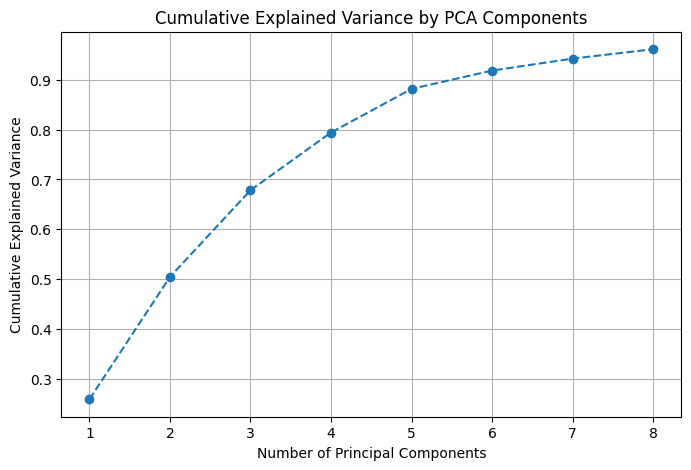

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# 1. Extract the features for PCA
features = expanded_df_with_demographics.drop(columns=['subject', 'label', 'gender'])
labels = expanded_df_with_demographics['label']

# 2. Scale the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# 3. Apply PCA
pca = PCA(n_components=0.95)  # Retain 95% of the variance
principal_components = pca.fit_transform(scaled_features)

# 4. Explained variance ratio
explained_variance = pca.explained_variance_ratio_
print("Explained variance ratio of each component:", explained_variance)
print("Total explained variance:", explained_variance.sum())

# 5. Convert PCA results back to a DataFrame
pca_columns = [f"PC{i+1}" for i in range(principal_components.shape[1])]
pca_df = pd.DataFrame(principal_components, columns=pca_columns)

# Add back labels for reference
pca_df['label'] = labels

# Display the PCA DataFrame
print(pca_df.head())

# 6. Visualize the explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance.cumsum(), marker='o', linestyle='--')
plt.title("Cumulative Explained Variance by PCA Components")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid()
plt.show()


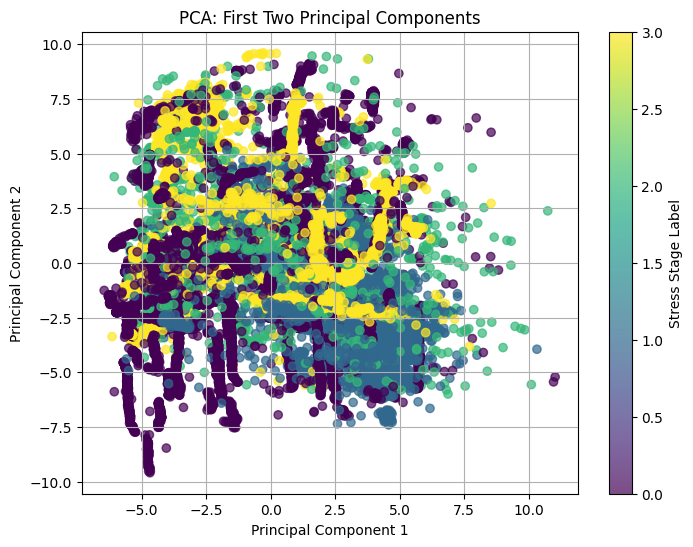

In [ ]:
# Scatter plot of the first two principal components
plt.figure(figsize=(8, 6))
scatter = plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['label'], cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label="Stress Stage Label")
plt.title("PCA: First Two Principal Components")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid()
plt.show()

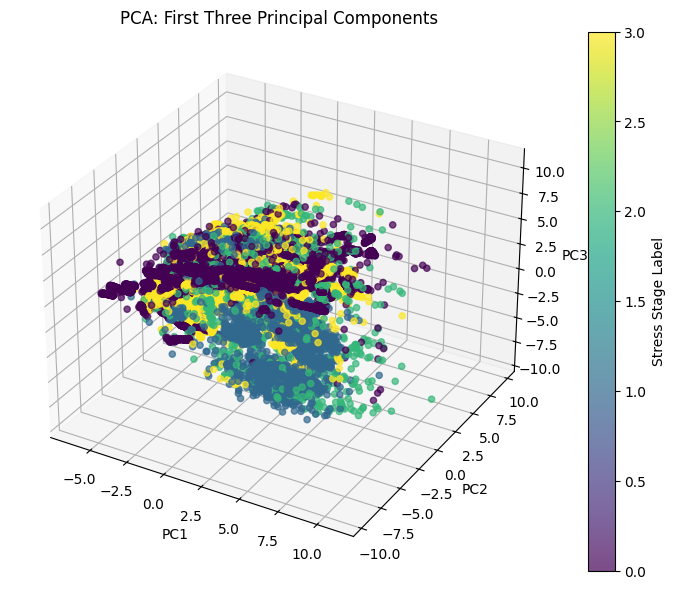

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

# 3D scatter plot of the first three principal components
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(pca_df['PC1'], pca_df['PC2'], pca_df['PC3'], c=pca_df['label'], cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label="Stress Stage Label")
ax.set_title("PCA: First Three Principal Components")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.show()



# **Feature Selection:**

#SFS (Sequential Feature Selection)

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.metrics import accuracy_score

X = expanded_df_with_demographics.drop(columns=['label'])
y = expanded_df_with_demographics['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#LDA model
lda = LinearDiscriminantAnalysis()

#SFS
sfs = SFS(lda,
          k_features='best',  # You can specify a fixed number, e.g., k_features=13
          forward=True,       # Forward selection
          floating=False,     # Disable floating SFS
          scoring='accuracy', # Use accuracy as the evaluation metric
          cv=5,               # 5-fold cross-validation
          n_jobs=-1)          # Use all available CPU cores

sfs = sfs.fit(X_train, y_train)

# Get the selected features
selected_features = list(sfs.k_feature_names_)
print("Selected features:", selected_features)

# Transform the dataset to include only the selected features
X_train_selected = sfs.transform(X_train)
X_test_selected = sfs.transform(X_test)

lda.fit(X_train_selected, y_train)
y_pred = lda.predict(X_test_selected)
print("Accuracy on test data:", accuracy_score(y_test, y_pred))


Selected features: ['ax_6', 'ay_7', 'az_3', 'az_4', 'az_6', 'az_8', 'EDA_3', 'EDA_6', 'spo2_1', 'hr_1', 'gender']
Accuracy on test data: 0.807414346895075


In [ ]:
from sklearn.metrics import accuracy_score, f1_score

# Calculate F1-score (weighted to account for class imbalance)
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy on test data: {accuracy:.4f}")
print(f"Weighted F1-score on test data: {f1:.4f}")

Accuracy on test data: 0.8074
Weighted F1-score on test data: 0.7767


#RFE (Recursive Feature Elimination)

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np

X = expanded_df_with_demographics.drop(columns=['label'])
y = expanded_df_with_demographics['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# LDA model
lda = LinearDiscriminantAnalysis()

f1_scores = []
accuracy_scores = []

# Perform RFE and evaluate the model for different numbers of features
for n_features in range(1, X_train.shape[1] + 1):
    rfe = RFE(estimator=lda, n_features_to_select=n_features)
    rfe.fit(X_train, y_train)

    X_train_rfe = rfe.transform(X_train)
    X_test_rfe = rfe.transform(X_test)

    lda.fit(X_train_rfe, y_train)
    y_pred = lda.predict(X_test_rfe)

    f1 = f1_score(y_test, y_pred, average='macro')
    accuracy = accuracy_score(y_test, y_pred)

    f1_scores.append(f1)
    accuracy_scores.append(accuracy)

# Find the number of features with the best F1 score and accuracy
optimal_f1_features = np.argmax(f1_scores) + 1
optimal_accuracy_features = np.argmax(accuracy_scores) + 1

print(f"\nOptimal number of features based on F1 Score: {optimal_f1_features}, with F1 Score: {f1_scores[optimal_f1_features-1]:.4f}")
print(f"Optimal number of features based on Accuracy: {optimal_accuracy_features}, with Accuracy: {accuracy_scores[optimal_accuracy_features-1]:.4f}")


Optimal number of features based on F1 Score: 47, with F1 Score: 0.5758
Optimal number of features based on Accuracy: 47, with Accuracy: 0.8075


In [ ]:
from sklearn.metrics import f1_score
weighted_f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Weighted F1 Score: {weighted_f1:.4f}")


Weighted F1 Score: 0.7820


# **Classification Methods:**

# KNN / Weighted KNN

**With PCA**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split


# Step 1: Extract the features and labels
X_pca = pca_df.drop(columns=['label'])
y_pca = pca_df['label']

# Step 2: Split into training and test sets
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y_pca, test_size=0.2, random_state=42, stratify=y_pca)

# Step 3: Train a KNN model on the PCA-transformed data
knn_pca = KNeighborsClassifier(n_neighbors=5)  # You can change the number of neighbors (n_neighbors)
knn_pca.fit(X_train_pca, y_train_pca)

# Step 4: Make predictions and evaluate performance
y_pred_pca = knn_pca.predict(X_test_pca)

f1_pca = f1_score(y_test_pca, y_pred_pca, average='macro')
accuracy_pca = accuracy_score(y_test_pca, y_pred_pca)

print(f"\nKNN with PCA - F1 Score: {f1_pca:.4f}, Accuracy: {accuracy_pca:.4f}")



KNN with PCA - F1 Score: 0.9411, Accuracy: 0.9817


**With RFE**

In [ ]:
optimal_features = optimal_accuracy_features

# Perform RFE with the optimal number of features
rfe = RFE(estimator=lda, n_features_to_select=optimal_features)
rfe.fit(X_train, y_train)

# Transform the data to keep only the selected features
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)

# Train the KNN model on the RFE-selected features
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_rfe, y_train)

# Make predictions and evaluate the model
y_pred_rfe = knn.predict(X_test_rfe)

# Calculate F1 score and accuracy
f1_rfe = f1_score(y_test, y_pred_rfe, average='weighted')
accuracy_rfe = accuracy_score(y_test, y_pred_rfe)

# Print results
print(f"\nKNN with RFE-selected features - Weighted F1 Score: {f1_rfe:.4f}, Accuracy: {accuracy_rfe:.4f}")



KNN with RFE-selected features - F1 Score: 0.9409, Accuracy: 0.9778


**PCA did better, therefore we will continue with this dimensionality reduction for the other models as well**

# MLP (Multi-layer Perceptron)

Training a Multilayer Perceptron classifier on the PCA-transformed data using all the principal components to predict the stress types or relaxed.

**Using PCA**

In [ ]:
print(pca_df.head())

        PC1       PC2       PC3       PC4        PC5       PC6       PC7  \
0 -1.014525 -2.661563  2.265404 -0.037414  -1.796037  2.923453 -0.517222   
1  7.437809  1.665123  2.416431 -1.146511  12.734744  2.521065  0.219065   
2 -4.389522  2.178783  1.298417 -1.040936   4.567639  2.867199 -0.333645   
3 -2.627524  1.203714 -1.054865 -3.487262  -1.150893  2.433329 -0.987758   
4 -1.027720 -2.655884  2.275868 -0.038803  -1.808894  2.909479 -0.499981   

        PC8  label  
0  0.246503      0  
1 -1.666246      0  
2 -0.245048      0  
3  0.022873      0  
4  0.263806      0  


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.decomposition import PCA

Xmlp = pca_df.drop(columns=['label'])
Ymlp = pca_df['label']

Xmlp_train, Xmlp_test, Ymlp_train, Ymlp_test = train_test_split(Xmlp, Ymlp, test_size=0.2, random_state=42, stratify=Ymlp)

# MLP classifier
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
mlp.fit(Xmlp_train, Ymlp_train)

Ymlp_pred = mlp.predict(Xmlp_test)

accuracy = accuracy_score(Ymlp_test, Ymlp_pred)
f1 = f1_score(Ymlp_test, Ymlp_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Weighted F1 Score: {f1:.4f}")


Accuracy: 0.9821
Weighted F1 Score: 0.9816


In [ ]:
print(expanded_df_with_demographics['label'].unique())

[0 1 2 3]


**0: Relaxed**


**1:  PhysicalStress**


**2: EmotionalStress**

**3:CognitiveStress**

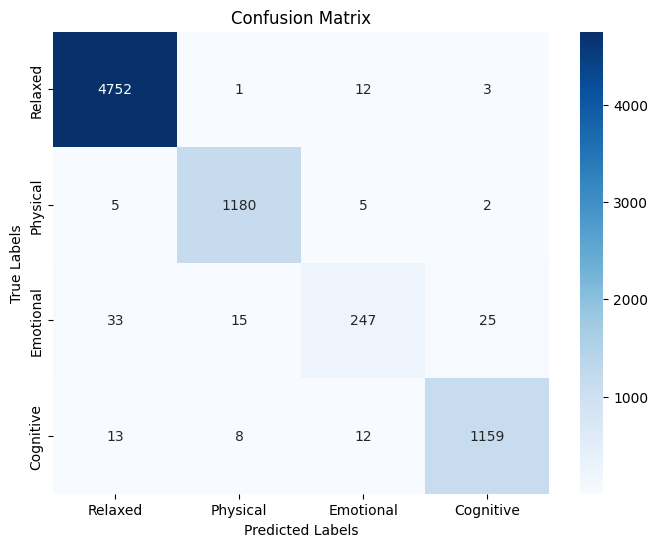

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(Ymlp_test, Ymlp_pred)

#class labels
labels = ['Relaxed', 'Physical', 'Emotional', 'Cognitive']

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()



#SVM (Nakhla)

#Clustering Methods:

#K Means (Nakhla)

# Hierarchical

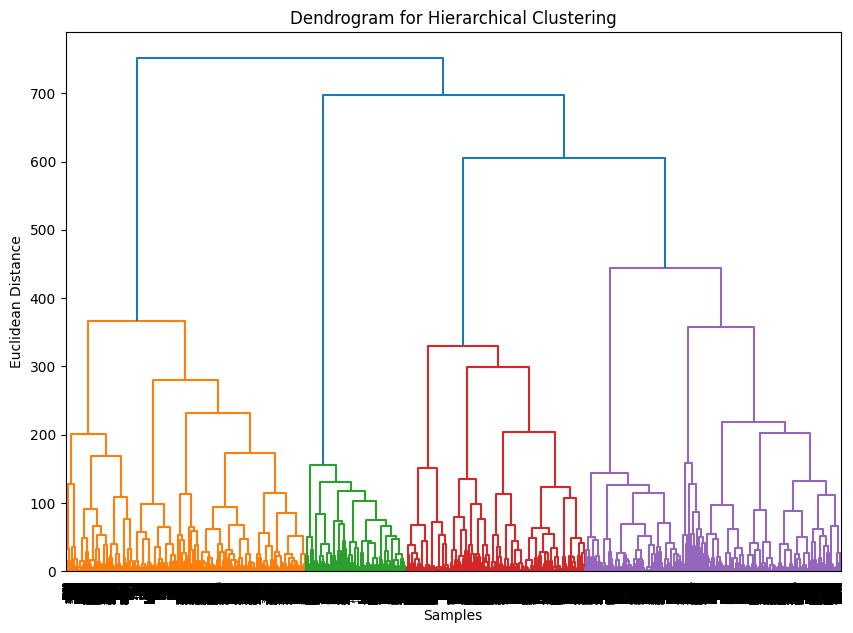

        PC1       PC2       PC3       PC4        PC5       PC6       PC7  \
0 -1.014525 -2.661563  2.265404 -0.037414  -1.796037  2.923453 -0.517222   
1  7.437809  1.665123  2.416431 -1.146511  12.734744  2.521065  0.219065   
2 -4.389522  2.178783  1.298417 -1.040936   4.567639  2.867199 -0.333645   
3 -2.627524  1.203714 -1.054865 -3.487262  -1.150893  2.433329 -0.987758   
4 -1.027720 -2.655884  2.275868 -0.038803  -1.808894  2.909479 -0.499981   

        PC8  label  Cluster  
0  0.246503      0        1  
1 -1.666246      0        0  
2 -0.245048      0        0  
3  0.022873      0        1  
4  0.263806      0        1  


In [ ]:
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt

X_pca = pca_df.drop(columns=['label'])

#Agglomerative Hierarchical Clustering
hierarchical = AgglomerativeClustering(n_clusters=3, linkage='ward')
y_hierarchical = hierarchical.fit_predict(X_pca)

# Add the cluster labels to the PCA DataFrame for analysis
pca_df['Cluster'] = y_hierarchical

# Visualize the clustering result using a dendrogram
plt.figure(figsize=(10, 7))
sch.dendrogram(sch.linkage(X_pca, method='ward'))  # 'ward' minimizes the variance within clusters
plt.title("Dendrogram for Hierarchical Clustering")
plt.xlabel("Samples")
plt.ylabel("Euclidean Distance")
plt.show()
print(pca_df.head())


# Spectral Clustering


We applied Spectral Clustering to the PCA-transformed data to group similar data points. We chose 4 clusters based on our 4 classes: Relaxed, PhysicalStress, EmotionalStress and CognitiveStress. The clustering was done using the nearest neighbors method, and the results were visualized in a 2D scatter plot using the first two principal components (PC1 and PC2). The number of samples in each cluster was also calculated.

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


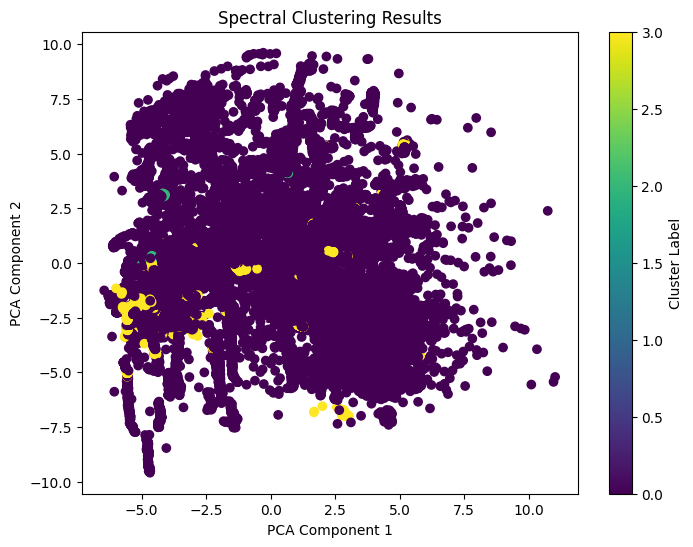

Cluster counts: {0: 34272, 1: 26, 2: 111, 3: 2951}


In [ ]:
from sklearn.cluster import SpectralClustering
import matplotlib.pyplot as plt

X_spectral = pca_df.drop(columns=['label'])

#Spectral clustering model
spectral_clustering = SpectralClustering(n_clusters=4, affinity='nearest_neighbors', random_state=42)
cluster_labels = spectral_clustering.fit_predict(X_spectral)

#Visualize the clusters
plt.figure(figsize=(8, 6))
plt.scatter(X_spectral.iloc[:, 0], X_spectral.iloc[:, 1], c=cluster_labels, cmap='viridis')
plt.title("Spectral Clustering Results")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label="Cluster Label")
plt.show()

# Number of samples in each cluster
import numpy as np
unique, counts = np.unique(cluster_labels, return_counts=True)
print(f"Cluster counts: {dict(zip(unique, counts))}")

